# TP Aprendizaje Automático 1
- Alsop Agustin
- Hachen Rocio

## Introducción

### Librerias

In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

### Funciones

In [103]:
# Funciones de Modelos
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(9, 5))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W


def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1) # se inicializan los pesos

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation] # se reordenan los datos en base a los indices de la permutación
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            

    plt.figure(figsize=(9, 5))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient) 

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(9, 5))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

In [104]:
#Funciones de Métricas
def calcular_score(X_test, y_test, W):
    # Añadimos una columna de 1s para el sesgo
    X_test_bias = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    # Predicciones del modelo
    y_pred = np.matmul(X_test_bias, W)

    # SSE: Error cuadrático residual
    SSE = np.sum((y_test - y_pred) ** 2)

    # SST: Total de errores cuadrados
    y_mean = np.mean(y_test)
    SST = np.sum((y_test - y_mean) ** 2)

    # Cálculo del R2
    R2 = 1 - (SSE / SST)

    return R2

def calcular_rmse(X_test, y_test, W):
    # Añadimos una columna de 1s para el sesgo
    X_test_bias = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
    
    # Predicciones del modelo
    y_pred = np.matmul(X_test_bias, W)
    
    # Calcular el error cuadrático medio (MSE)
    mse = np.mean((y_test - y_pred) ** 2)
    
    # Calcular la raíz cuadrada del MSE para obtener el RMSE
    rmse = np.sqrt(mse)
    
    return rmse

In [105]:
def plot_residuos(X_train, y_train, X_test, y_test, W):
    # Añadir columna de unos para el término independiente
    X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    # Calcular predicciones
    prediction_train = np.matmul(X_train, W)
    prediction_test = np.matmul(X_test, W)

    # Calcular los residuos
    residuals_train = y_train - prediction_train
    residuals_test = y_test - prediction_test

    # Graficar el histograma de los residuos para el conjunto de entrenamiento
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals_train, kde=True, bins=30, color='blue')
    plt.axvline(0, color='red', linestyle='--')
    plt.title('Histograma de Residuos (Entrenamiento)')
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.show()

    # Graficar el histograma de los residuos para el conjunto de prueba
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals_test, kde=True, bins=30, color='green')
    plt.axvline(0, color='red', linestyle='--')
    plt.title('Histograma de Residuos (Prueba)')
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.show()


### Carga de datos

In [106]:
df = pd.read_csv('house-prices-tp.csv')

In [107]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44,22.2
1,0.08265,0.0,13.92,0.0,0.437,6.127,18.4,5.5027,4.0,289.0,16.0,396.90,8.58,23.9
2,0.12816,12.5,6.07,0.0,0.409,5.885,33.0,6.4980,4.0,345.0,18.9,396.90,8.79,20.9
3,0.08873,21.0,5.64,0.0,0.439,5.963,45.7,6.8147,4.0,243.0,16.8,395.56,13.45,19.7
4,0.11432,0.0,8.56,0.0,0.520,6.781,71.3,2.8561,5.0,384.0,20.9,395.58,7.67,26.5


## Ejercicio 3

### Codificación de Variables

In [108]:
# Cambiamos el tipo de dato de la variable categórica a 'category'
df['CHAS'] = df['CHAS'].astype('category')

### Análisis y decisión sobre datos faltantes.




In [109]:
# Guardamos la cantidad total de filas para luego compararlas
con_null = df.shape[0]

In [110]:
# Nulls por Variable
nulls = df.isna().sum()
print(nulls)

print(f' Valores null totales: {nulls.sum()}')

CRIM       23
ZN         22
INDUS      15
CHAS       23
NOX        24
RM         21
AGE        24
DIS        15
RAD        28
TAX        18
PTRATIO    28
B          22
LSTAT      22
MEDV       21
dtype: int64
 Valores null totales: 306


### Tratamiento de NAs
1) Las filas que tengan Nulls en la columna de la variable a predecir se descartán

2) Las filas que tengan al menos un 50% de Nulls se borrarán, ya que consideramos que rellenarlo por imputación resultaría en un dato creado artificialmente. Verificamos que al hacer esto no se borrara una gran cantidad de información.

3) Para el resto de los datos Null, y luego de haber hecho la validación cruzada, se realizarán imputaciones dependiendo de su distribución y tipo de variable.
    - Asimetría -> Mediana
    - Normal -> Media
    - Bimodal y Categorica -> KNN

#### Paso 1

In [111]:
# Eliminación de las row donde la variable de salida sea null
df = df.dropna(subset=['MEDV'])
print(df['MEDV'].isna().sum())

0


#### Paso 2

In [112]:
# Nos quedamos solo con aquellas rows con al menos 7 variables no Null
df = df.dropna(thresh=7)
df.isna().sum()

CRIM        8
ZN         10
INDUS       1
CHAS        7
NOX         7
RM          5
AGE         9
DIS         3
RAD        11
TAX         8
PTRATIO     7
B           7
LSTAT       7
MEDV        0
dtype: int64

In [113]:
sin_null = df.shape[0] # Cantidad de filas restantes luego de la eliminación de Nulls
print(f'Cantidad de filas en el dataset al comienzo: {con_null}\nCantidad de filas en el dataset luego de quitar nulls: {sin_null}\nFilas perdidas: {con_null - sin_null}\nPorcentaje de filas perdidas: {round((con_null-sin_null)*100/con_null,2)}%')

Cantidad de filas en el dataset al comienzo: 556
Cantidad de filas en el dataset luego de quitar nulls: 532
Filas perdidas: 24
Porcentaje de filas perdidas: 4.32%


### Validación Cruzada

In [114]:
# Division train - test - validation
x = df.drop(columns='MEDV')
y = df['MEDV']

ratio_train = 0.8
ratio_test = 0.20
#ratio_val = 0.15

# Test Split
x_train, x_test, y_train, y_test = train_test_split(
    x, y.values.reshape(-1,1), test_size=ratio_test, random_state=42) # se utiliza 42 para garantizar que cada vez que se corra el código se obtengan los mismos resultados

'''# Ajustamos
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining'''

'''# Validation and Train Split
x_train, x_val, y_train, y_val = train_test_split(
    x_remaining, y_remaining, test_size=ratio_val_adjusted)'''


x_train.shape, x_test.shape, y_train.shape, y_test.shape

((425, 13), (107, 13), (425, 1), (107, 1))

### Análisis descriptivo

In [115]:
print(df.describe(include='all'))

              CRIM          ZN       INDUS   CHAS         NOX          RM  \
count   524.000000  522.000000  531.000000  525.0  525.000000  527.000000   
unique         NaN         NaN         NaN    2.0         NaN         NaN   
top            NaN         NaN         NaN    0.0         NaN         NaN   
freq           NaN         NaN         NaN  480.0         NaN         NaN   
mean      4.986916   12.379853   11.226209    NaN    0.558437    6.277408   
std      11.942453   24.247117    6.924961    NaN    0.118669    0.754108   
min       0.006320    0.000000    0.460000    NaN    0.385000    3.561000   
25%       0.083545    0.000000    5.130000    NaN    0.453000    5.876500   
50%       0.290250    0.000000    9.690000    NaN    0.538000    6.202000   
75%       4.545407   20.000000   18.100000    NaN    0.631000    6.630500   
max      88.976200  100.000000   27.740000    NaN    0.871000    8.780000   

               AGE         DIS         RAD         TAX     PTRATIO  \
count

#### Matriz de Correlación

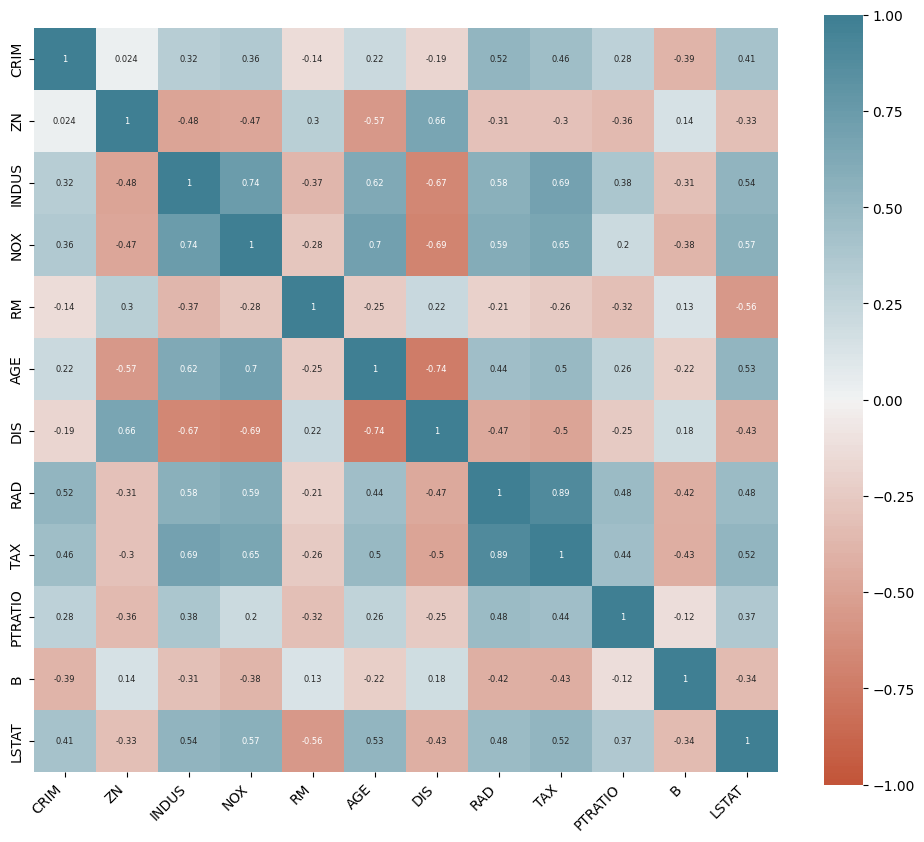

In [116]:
x_train_corr=pd.DataFrame(x_train,columns=x_train.drop(columns=['CHAS']).columns)
#X_test=pd.DataFrame(X_test,columns=df.drop(columns='MEDV').columns)
#y_train = pd.DataFrame(y_train,columns=['MEDV'])
#data_train=pd.concat([x_train,y_train],axis=1)
x_train_corr
plt.figure(figsize=(12,10))
corr = x_train_corr.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

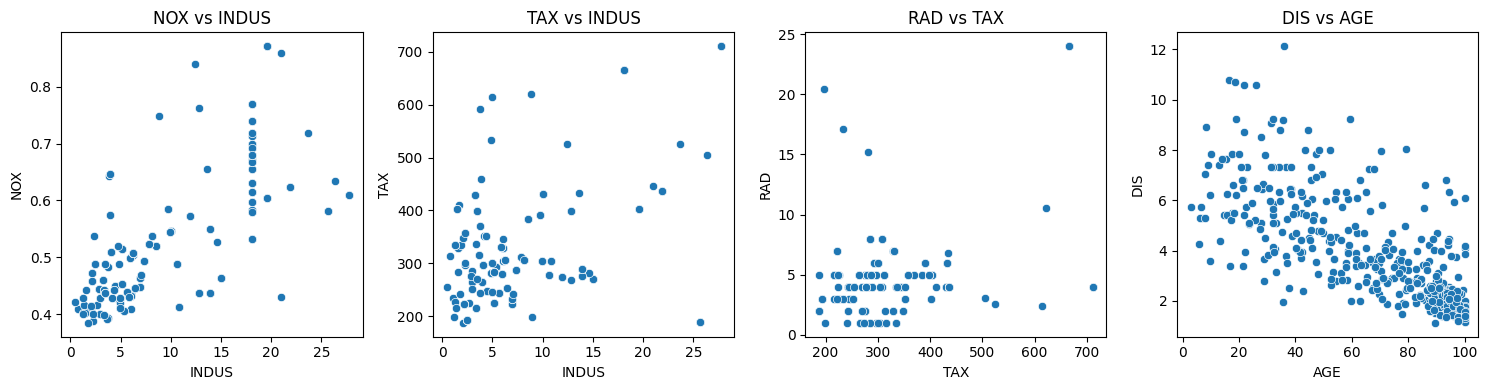

In [117]:
# Visualización de la relación entre algunas variables

pares = [('NOX', 'INDUS'), ('TAX', 'INDUS'), ('RAD', 'TAX'), ('DIS','AGE')]

fig, axes = plt.subplots(1, 4, figsize=(15, 4))

for i, (var1, var2) in enumerate(pares):
    sns.scatterplot(x=x_train_corr[var2], y=x_train_corr[var1], ax=axes[i])
    axes[i].set_title(f'{var1} vs {var2}')
    axes[i].set_xlabel(var2)
    axes[i].set_ylabel(var1)

plt.tight_layout()
plt.show()

#### Analisis por variable individual

CRIM
count    524.000000
mean       4.986916
std       11.942453
min        0.006320
25%        0.083545
50%        0.290250
75%        4.545407
max       88.976200
Name: CRIM, dtype: float64 



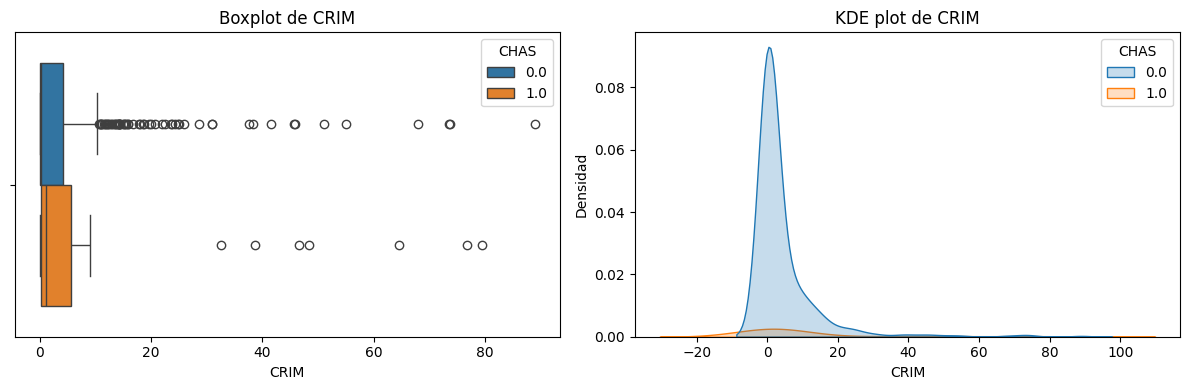

ZN
count    522.000000
mean      12.379853
std       24.247117
min        0.000000
25%        0.000000
50%        0.000000
75%       20.000000
max      100.000000
Name: ZN, dtype: float64 



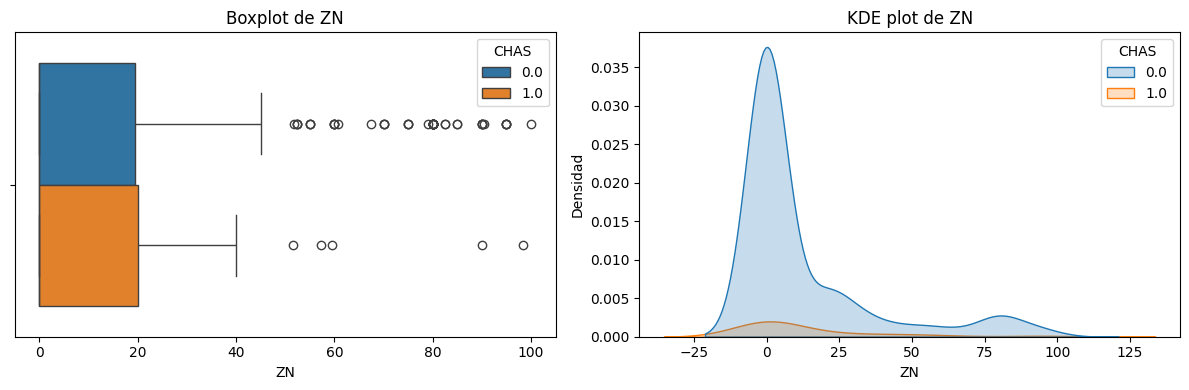

INDUS
count    531.000000
mean      11.226209
std        6.924961
min        0.460000
25%        5.130000
50%        9.690000
75%       18.100000
max       27.740000
Name: INDUS, dtype: float64 



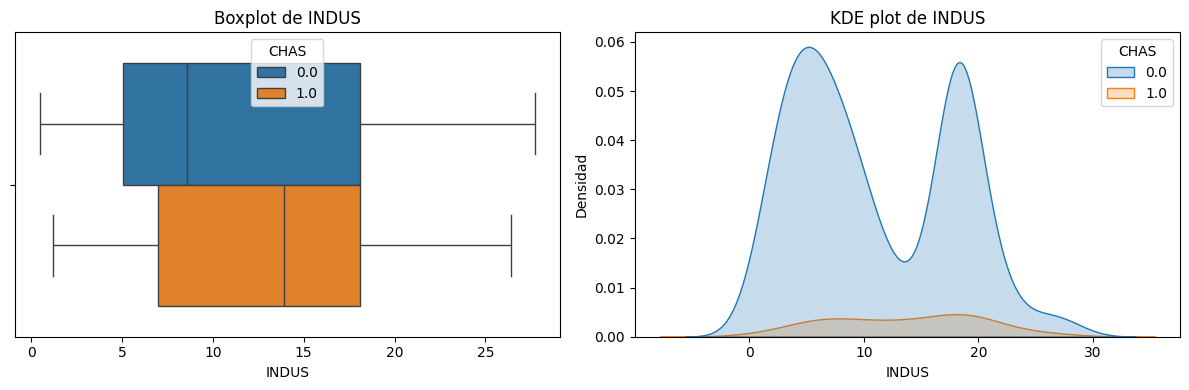

NOX
count    525.000000
mean       0.558437
std        0.118669
min        0.385000
25%        0.453000
50%        0.538000
75%        0.631000
max        0.871000
Name: NOX, dtype: float64 



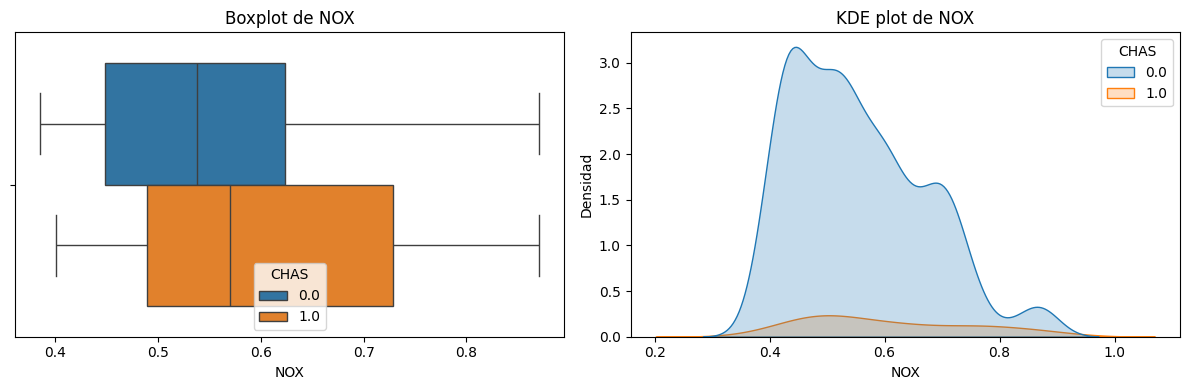

RM
count    527.000000
mean       6.277408
std        0.754108
min        3.561000
25%        5.876500
50%        6.202000
75%        6.630500
max        8.780000
Name: RM, dtype: float64 



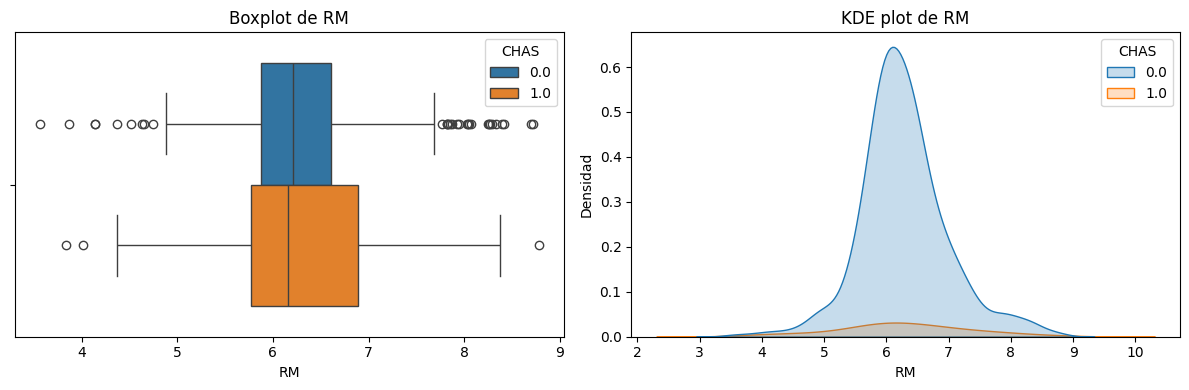

AGE
count    523.000000
mean      67.769735
std       28.473788
min        2.900000
25%       42.350000
50%       76.500000
75%       93.900000
max      100.000000
Name: AGE, dtype: float64 



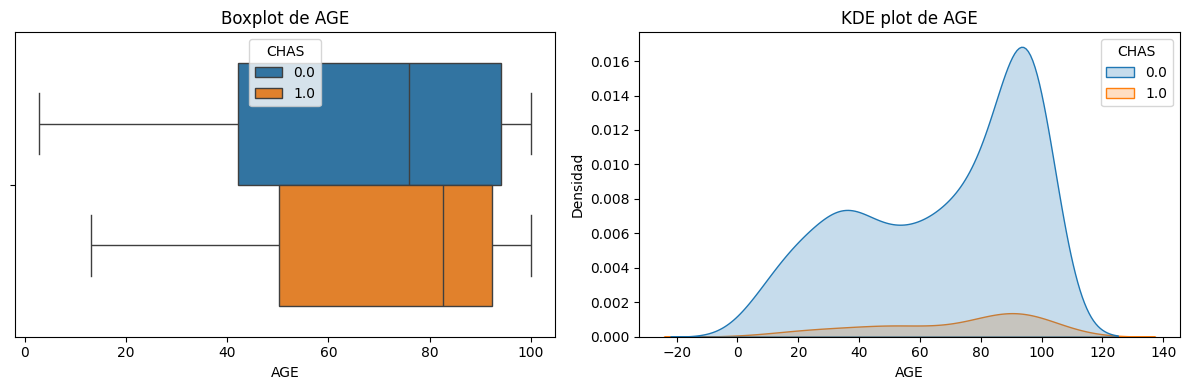

DIS
count    529.000000
mean       3.887920
std        2.201751
min        1.129600
25%        2.106900
50%        3.317500
75%        5.287300
max       12.126500
Name: DIS, dtype: float64 



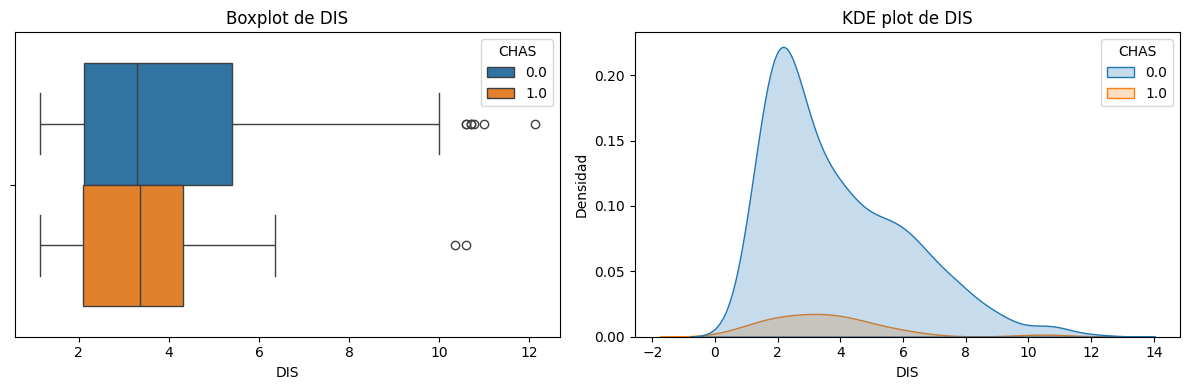

RAD
count    521.000000
mean       9.609005
std        8.676717
min        1.000000
25%        4.000000
50%        5.000000
75%       24.000000
max       24.000000
Name: RAD, dtype: float64 



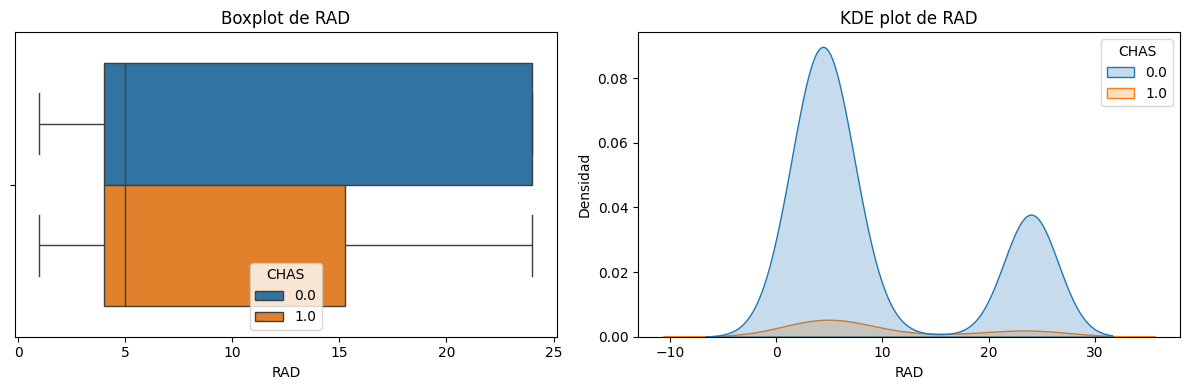

TAX
count    524.000000
mean     409.637836
std      167.953113
min      187.000000
25%      279.000000
50%      334.000000
75%      666.000000
max      711.000000
Name: TAX, dtype: float64 



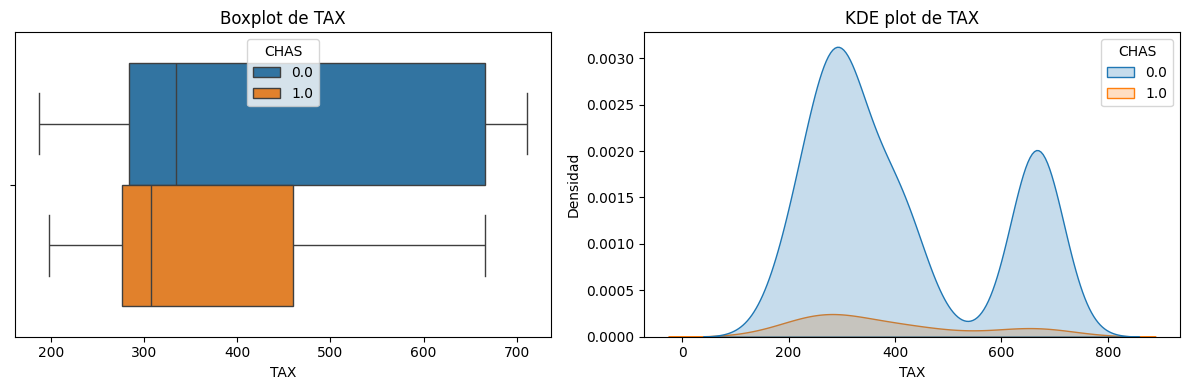

PTRATIO
count    525.000000
mean      18.422824
std        2.197179
min       12.600000
25%       17.000000
50%       19.000000
75%       20.200000
max       22.000000
Name: PTRATIO, dtype: float64 



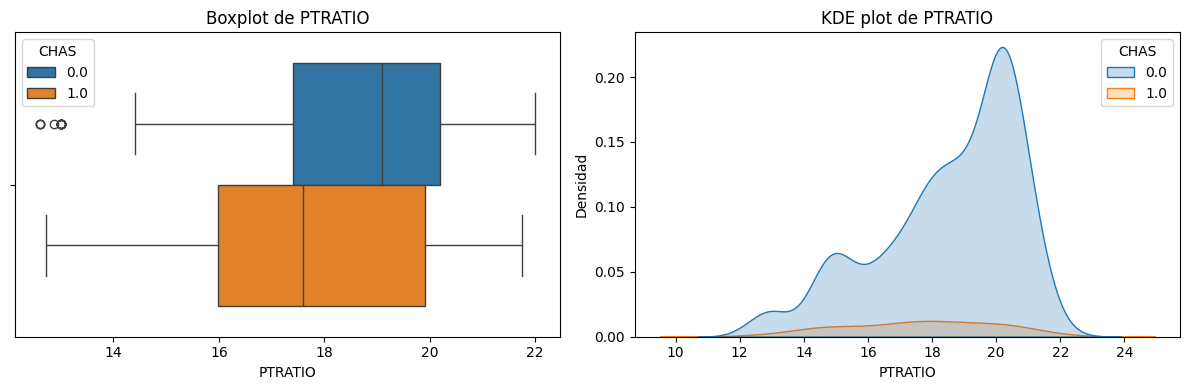

B
count    525.000000
mean     351.069549
std       96.805981
min        0.320000
25%      371.720000
50%      390.950000
75%      396.060000
max      396.900000
Name: B, dtype: float64 



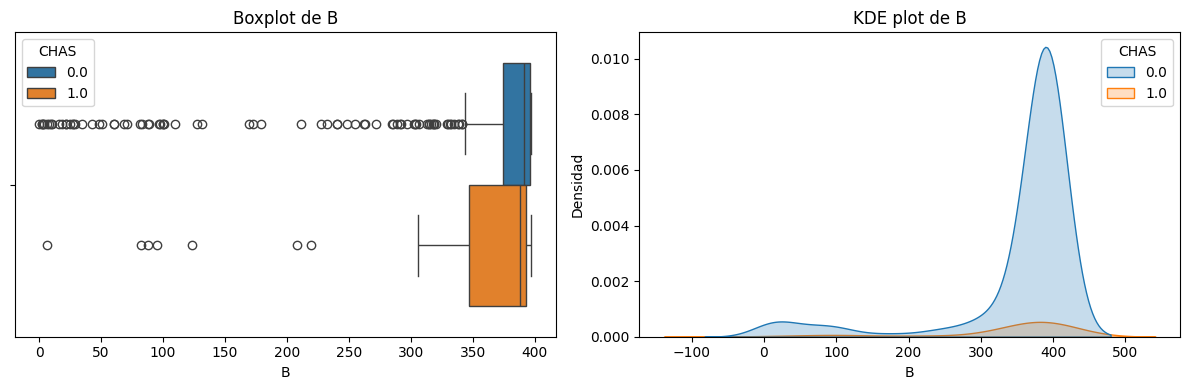

LSTAT
count    525.000000
mean      12.959729
std        7.517236
min        1.730000
25%        7.120000
50%       11.450000
75%       17.160000
max       37.970000
Name: LSTAT, dtype: float64 



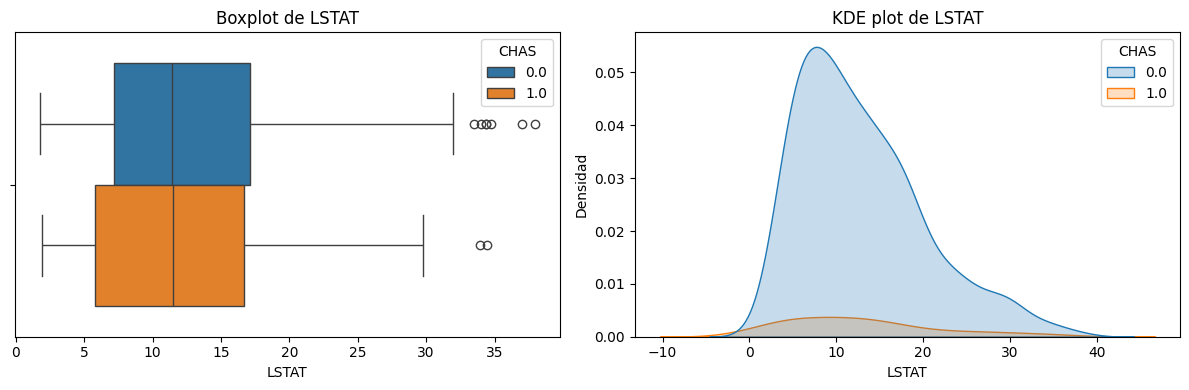

MEDV
count    532.000000
mean      22.754873
std        9.484397
min        5.000000
25%       16.775000
50%       21.300000
75%       26.250000
max       50.000000
Name: MEDV, dtype: float64 



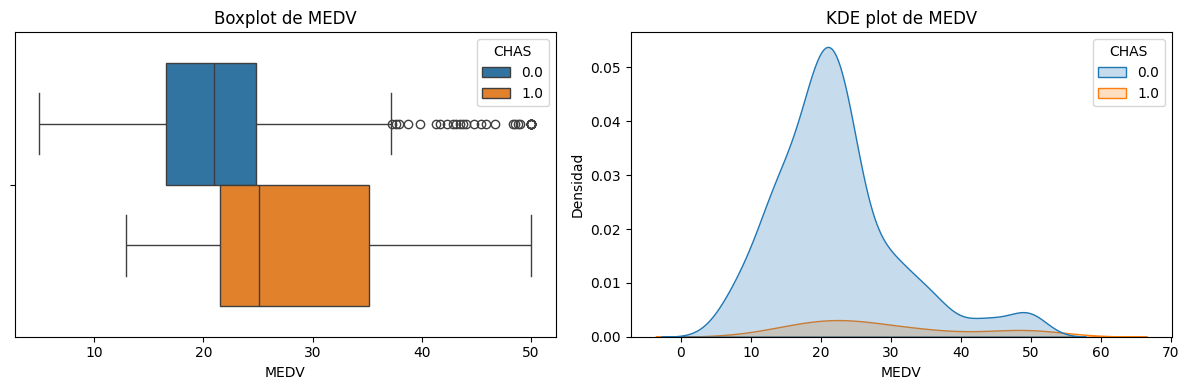

In [118]:
for columna in df:
    if columna != 'CHAS':
        print(columna)
        print(df[columna].describe(), '\n')

        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        sns.boxplot(data=df, x=columna, hue='CHAS', ax=axs[0])
        axs[0].set_title(f'Boxplot de {columna}')

        sns.kdeplot(data=df, x=columna, fill=True, hue='CHAS', ax=axs[1])
        axs[1].set_title(f'KDE plot de {columna}')
        axs[1].set_ylabel('Densidad')


        plt.tight_layout()
        plt.show()


#### Paso 3 (Imputación de datos)

En base al análisis descriptivo, decidimos utilizar distintos métodos de imputación según la distribución y el tipo de variable.

- CRIM: Mediana
- ZN: Mediana
- INDUS: KNN
- CHAS: KNN
- NOX: Mediana
- RM: Media
- AGE: KNN
- DIS: Mediana
- RAD: KNN
- TAX: KNN
- PTRATIO: Mediana
- B: Mediana
- LSTAT: Media

In [119]:
#Imputación mediante la mediana

imputer_median = SimpleImputer(strategy='median')
x_train_imputer= x_train.copy()
x_test_imputer = x_test.copy()
#x_val_imputer = x_val.copy()

x_train_imputer[['CRIM', 'ZN', 'NOX', 'DIS', 'PTRATIO','B']]= imputer_median.fit_transform(x_train_imputer[['CRIM', 'ZN', 'NOX', 'DIS', 'PTRATIO','B']])
x_test_imputer[['CRIM', 'ZN', 'NOX', 'DIS', 'PTRATIO','B']]= imputer_median.transform(x_test_imputer[['CRIM', 'ZN', 'NOX', 'DIS', 'PTRATIO','B']])
#x_val_imputer[['CRIM', 'ZN', 'NOX', 'DIS', 'PTRATIO','B']]= imputer_median.transform(x_val_imputer[['CRIM', 'ZN', 'NOX', 'DIS', 'PTRATIO','B']])
x_train_imputer.isna().sum()

CRIM       0
ZN         0
INDUS      1
CHAS       6
NOX        0
RM         4
AGE        7
DIS        0
RAD        8
TAX        5
PTRATIO    0
B          0
LSTAT      6
dtype: int64

In [120]:
#Imputación mediante la media en las columnas mencionadas anteriormente
imputer_mean = SimpleImputer(strategy='mean')
x_train_imputer[['RM', 'LSTAT']]= imputer_mean.fit_transform(x_train_imputer[['RM', 'LSTAT']])
x_test_imputer[['RM', 'LSTAT']]= imputer_mean.transform(x_test_imputer[['RM', 'LSTAT']])
#x_val_imputer[['RM', 'LSTAT']]= imputer_mean.transform(x_val_imputer[['RM', 'LSTAT']])
"""
print(X_train.median())
print(X_train_imputer.loc[158])
print(X_train.loc[158])
"""
x_train_imputer.isna().sum()

CRIM       0
ZN         0
INDUS      1
CHAS       6
NOX        0
RM         0
AGE        7
DIS        0
RAD        8
TAX        5
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [121]:
#Imputación mediante KNN en las columnas mencionadas anteriormente
knn_imputer = KNNImputer()
x_train_imputer[['INDUS', 'CHAS','AGE', 'RAD', 'TAX']]= knn_imputer.fit_transform(x_train_imputer[['INDUS', 'CHAS','AGE', 'RAD', 'TAX']])
x_test_imputer[['INDUS', 'CHAS','AGE', 'RAD', 'TAX']]= knn_imputer.transform(x_test_imputer[['INDUS', 'CHAS','AGE', 'RAD', 'TAX']])
#x_val_imputer[['INDUS', 'CHAS','AGE', 'RAD', 'TAX']]= knn_imputer.transform(x_val_imputer[['INDUS', 'CHAS','AGE', 'RAD', 'TAX']])


In [122]:
#Escalado de Datos
scaler=StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_imputer)
x_test_scaled = scaler.transform(x_test_imputer)
#x_val_scaled = scaler.transform(x_val_imputer)

#x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)
#x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns)
#x_val_scaled = pd.DataFrame(x_val_scaled, columns=x_val.columns)
x_train_imputer.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

## Ejercicio 4

### Regresión Lineal

In [123]:
#Escalado de datos
lr_income = LinearRegression()
lr_income.fit(x_train_scaled, y_train)

LinearRegression()

In [124]:
lr_income.intercept_

array([23.06502135])

In [125]:
lr_income.coef_[0]

array([ 0.1954151 ,  0.9792691 ,  0.20119915,  1.60848438, -0.91518728,
        3.39507795, -1.41629247, -2.56176452,  1.57935329, -2.06202558,
       -1.88281178,  0.72463384, -2.81195294])

$y_i = 23.06 + 0.19 x_1 +  0.97x_2 + 0.2x_3 + 1.6x_4 -0.9x_5 + 3.39x_6 -1.41x_7 -2.56x_8 + 1.57x_9 -2.06x_{10} -1.88x_{11} + 0.72x_{12} -2.81x_{13}$

In [126]:
# Scores R2 y RMSE de LinealRegression

a = lr_income.coef_.tolist()[0]
a.insert(0, lr_income.intercept_.tolist()[0])
a = np.array(a)

LR = []
LR.append(['Regresión lineal', 
           lr_income.score(x_train_scaled,y_train), 
           #lr_income.score(x_val_scaled,y_val), 
           lr_income.score(x_test_scaled,y_test), 
           calcular_rmse(x_test_scaled, y_test, a), 
           calcular_rmse(x_train_scaled, y_train, a)])

comparacion = pd.DataFrame(data=LR, columns=['Modelos', 'R2 train', 'R2 test', 'RMSE train', 'RMSE test'])

comparacion

,Modelos,R2 train,R2 test,RMSE train,RMSE test
0,Regresión lineal,0.637984,0.545689,11.365487,12.358655


### Gradiente Estocástico

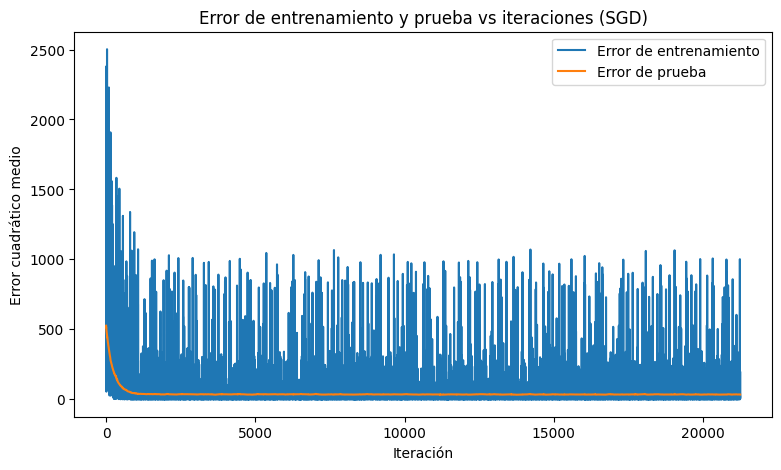

Coeficientes obtenidos: 


array([[23.08463881],
       [ 0.17874363],
       [ 0.90814521],
       [ 0.29139655],
       [ 1.63785761],
       [-0.83134549],
       [ 3.29458502],
       [-1.34774334],
       [-2.65431228],
       [ 1.62932458],
       [-1.97640747],
       [-1.84814903],
       [ 0.78175242],
       [-2.77834594]])

In [127]:
W_SGD = stochastic_gradient_descent(x_train_scaled, y_train, x_test_scaled, y_test, lr=0.001, epochs=50)

print('Coeficientes obtenidos: ')
W_SGD

Tiene mucho ruido

In [128]:
# Llamada a la función
GE_r2_train = calcular_score(x_train_scaled,y_train, W_SGD)
GE_r2_test = calcular_score(x_test_scaled, y_test, W_SGD)
#GE_r2_val = calcular_score(x_val_scaled,y_val, W_SGD)

print('R2 Score - Gradiente Estocástico')
print(f'R2 Train: {GE_r2_train}, R2 Test: {GE_r2_test}')

R2 Score - Gradiente Estocástico
R2 Train: 0.635346019251213, R2 Test: 0.5484684009278065


In [129]:
GE_rmse_train = calcular_rmse(x_train_scaled, y_train, W_SGD)
GE_rmse_test = calcular_rmse(x_test_scaled, y_test, W_SGD)

print(f' RMSE Train: {GE_rmse_train}, RMSE Test: {GE_rmse_test}')

 RMSE Train: 5.8311862643185295, RMSE Test: 5.785685096883081


In [130]:
data = []
data.append(['Gradiente Estocástico',
           GE_r2_train,
           #GE_r2_val,
           GE_r2_test,
           GE_rmse_train,
           GE_rmse_test])

### Gradiente descendiente

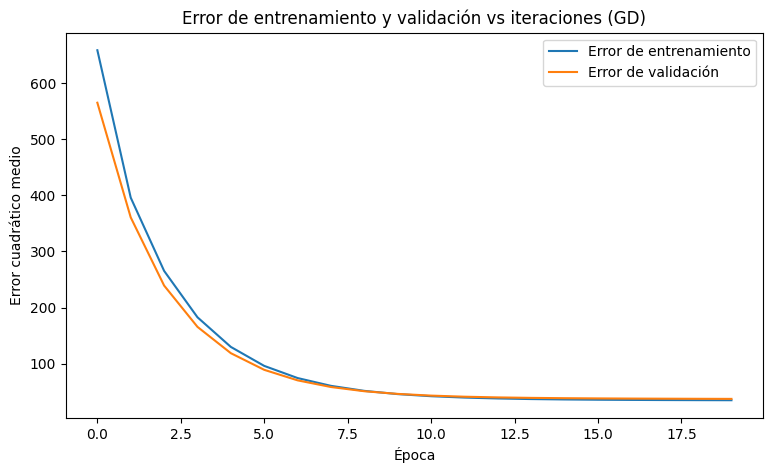

Coeficientes obtenidos: 


array([[22.79914321],
       [ 0.17058338],
       [ 0.71737679],
       [ 0.04385007],
       [ 1.71947876],
       [-0.84115975],
       [ 3.45908773],
       [-0.81429687],
       [-1.77583181],
       [ 0.13946268],
       [-0.60961647],
       [-1.73104391],
       [ 0.62484718],
       [-2.96254863]])

In [131]:
W_GD = gradient_descent(x_train_scaled,y_train,x_test_scaled,y_test, lr=0.1, epochs=20)

print('Coeficientes obtenidos: ')
W_GD

Si intentamos con un LR menor o mayor a 0.1, el resultado empeora. Con un LR menor, no logra converger, mientras que con un LR mayor, termina divergiendo.

lr = 0.01


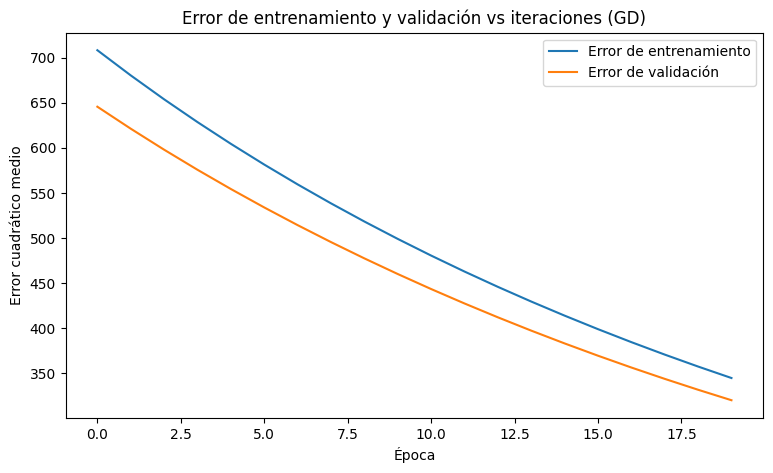

lr = 0.001


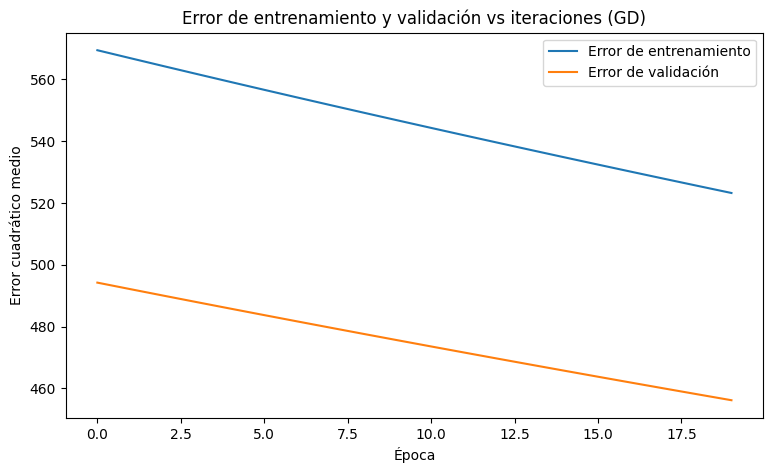

lr = '0.2'


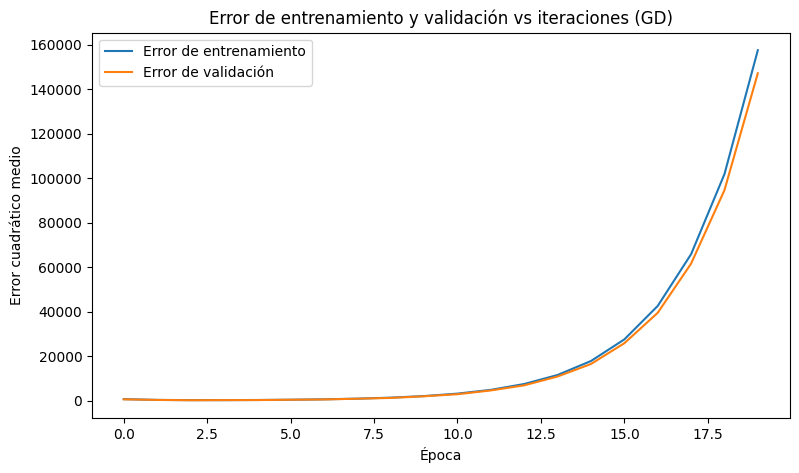

In [132]:
print("lr = 0.01")
W_GD2= gradient_descent(x_train_scaled,y_train,x_test_scaled,y_test, lr=0.01, epochs=20)
print("lr = 0.001")
W_GD3= gradient_descent(x_train_scaled,y_train,x_test_scaled,y_test, lr=0.001, epochs=20)
print("lr = '0.2'")
W_GD3= gradient_descent(x_train_scaled,y_train,x_test_scaled,y_test, lr=0.2, epochs=20)

Con más epochs, observamos que los errores convergen en los primeros 20 epochs, por lo que parecería innecesario seguir más allá de eso.
Con menos epochs (5) no se llega a apreciar que converge.

100 epochs


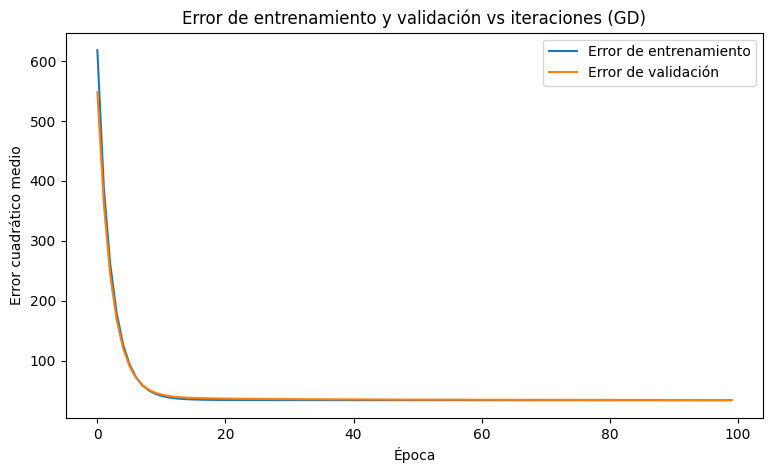

5 epochs


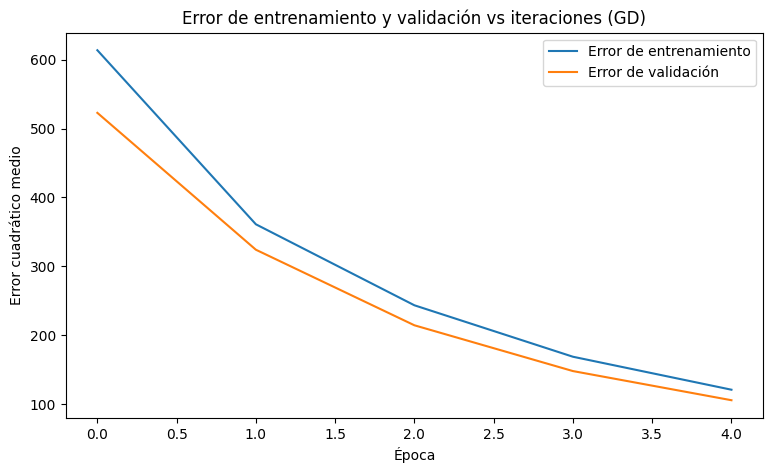

In [133]:
print("100 epochs")
W_GD2= gradient_descent(x_train_scaled,y_train,x_test_scaled,y_test, lr=0.1, epochs=100)
print("5 epochs")
W_GD3= gradient_descent(x_train_scaled,y_train,x_test_scaled,y_test, lr=0.1, epochs=5)

In [134]:
# Calculamos R2 para Gradiente Descendiente

GD_r2_train = calcular_score(x_train_scaled,y_train, W_GD)
GD_r2_test = calcular_score(x_test_scaled, y_test, W_GD)
#GD_r2_val = calcular_score(x_val_scaled,y_val, W_GD)

print('R2 Score - Gradiente Descendiente')
print(f'R2 Train: {GD_r2_train}, R2 Test: {GD_r2_test}')

R2 Score - Gradiente Descendiente
R2 Train: 0.6295014064319817, R2 Test: 0.5022771639746331


In [135]:
# Calculamos RMSE para Gradiente Descendiente

GD_rmse_train = calcular_rmse(x_train_scaled, y_train, W_GD)
GD_rmse_test = calcular_rmse(x_test_scaled, y_test, W_GD)

print(f' RMSE Train: {GD_rmse_train}, RMSE Test: {GD_rmse_test}')

 RMSE Train: 5.877731139859758, RMSE Test: 6.074415589769649


In [136]:
# Agregamos los puntajes a la tabla de comparación

data.append(['Gradiente Descendiente',
           GD_r2_train,
           #GD_r2_val,
           GD_r2_test,
           GD_rmse_train,
           GD_rmse_test])

### Mini-batch Gradiente

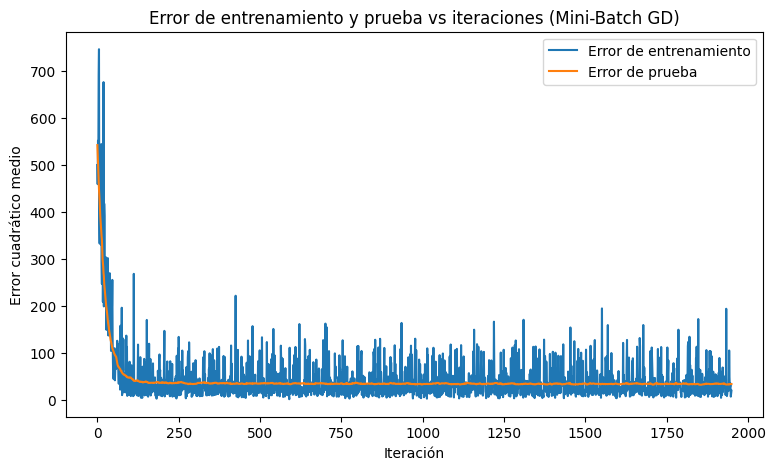

Coeficientes obtenidos: 


array([[23.09529949],
       [ 0.30712631],
       [ 0.9802297 ],
       [ 0.1764539 ],
       [ 1.58496287],
       [-0.91773727],
       [ 3.41622993],
       [-1.42924867],
       [-2.52536745],
       [ 1.5205669 ],
       [-2.04943495],
       [-1.87452318],
       [ 0.7120357 ],
       [-2.80630006]])

In [137]:
W_MBG = mini_batch_gradient_descent(x_train_scaled, y_train, x_test_scaled, y_test, epochs=50, lr=0.01)
GMB_r2_train = calcular_score(x_train_scaled,y_train, W_MBG)
GMB_r2_test = calcular_score(x_test_scaled, y_test, W_MBG)
#GMB_r2_val = calcular_score(x_val_scaled,y_val, W_MBG)

print('Coeficientes obtenidos: ')
W_MBG

Si achicamos el LR, necesitaremos más epochs para llegar a la convergencia.

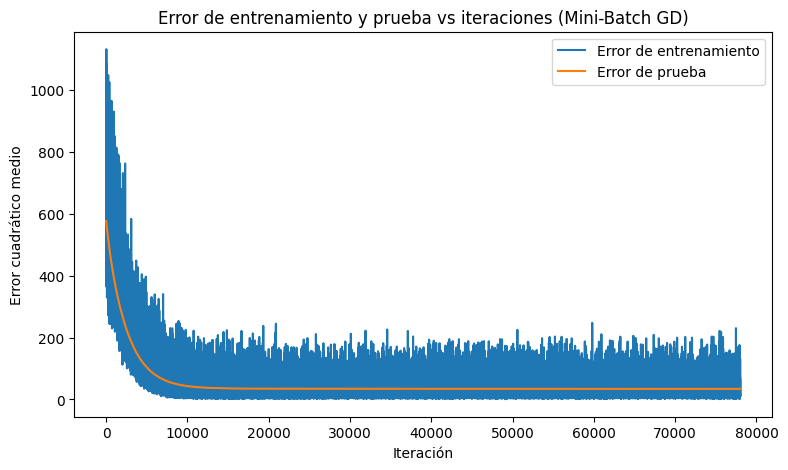

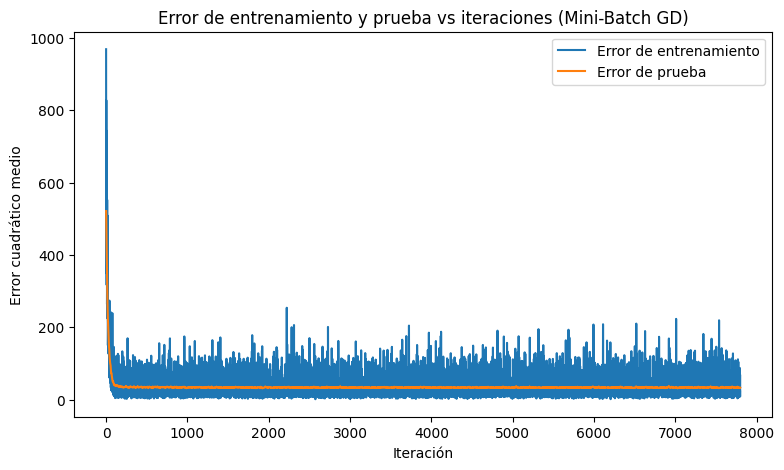

In [138]:
W_MBG2 = mini_batch_gradient_descent(x_train_scaled, y_train, x_test_scaled, y_test, epochs=2000, lr=0.0001)
W_MBG3 = mini_batch_gradient_descent(x_train_scaled, y_train, x_test_scaled, y_test, epochs=200, lr=0.01)


In [139]:
GMB_r2_train = calcular_score(x_train_scaled,y_train, W_MBG)
GMB_r2_test = calcular_score(x_test_scaled, y_test, W_MBG)
#GMB_r2_val = calcular_score(x_val_scaled,y_val, W_MBG)

print('R2 Score - Gradiente Mini-batch')
print(f'R2 Train: {GMB_r2_train}, R2 Test: {GMB_r2_test}')

R2 Score - Gradiente Mini-batch
R2 Train: 0.6378043461383056, R2 Test: 0.5448402728748408


In [140]:
GMB_rmse_train = calcular_rmse(x_train_scaled, y_train, W_MBG)
GMB_rmse_test = calcular_rmse(x_test_scaled, y_test, W_MBG)

print(f'RMSE Train: {GMB_rmse_train}, RMSE Test: {GMB_rmse_test}')

RMSE Train: 5.8114974573636236, RMSE Test: 5.808883039278423


In [141]:
data.append(['Gradiente Mini Batch',
           GMB_r2_train,
           #GMB_r2_val,
           GMB_r2_test,
           GMB_rmse_train,
           GMB_rmse_test])

### LASSO

In [142]:
# Crear modelos de regresión lineal, Lasso y Ridge
#lassoCV = LassoCV()  # habiamos usado la version CV, pero decidimos cambiarlo así podriamos cambiar el alpha nosotros

lassoCV = Lasso(alpha=0.01)  # alpha controla la fuerza de la regularización L1 (Lasso)

# Ajustar modelos a los datos
lassoCV.fit(x_train_scaled, y_train)

'''#Mostrar alphas
print(f'Alpha: {lassoCV.alpha_}') # lambda'''

print(f'LassoCV Intercept: {lassoCV.intercept_}')

# Mostrar coeficientes
print("\nCoeficientes del modelo Lasso:")
print(lassoCV.coef_,'\n')

lasso_r2train = lassoCV.score(x_train_scaled,y_train)
lasso_r2test = lassoCV.score(x_test_scaled,y_test)
#lasso_r2val = lassoCV.score(x_val_scaled,y_val)

print(f'R2 Train: {lasso_r2train}')
print(f'R2 Test: {lasso_r2test}\n')

W = list(lassoCV.coef_)
W.insert(0,lassoCV.intercept_[0])
W = np.array(W).reshape(14, 1)


lasso_rmsetrain = calcular_rmse(x_train_scaled,y_train,W)
lasso_rmsetest = calcular_rmse(x_test_scaled,y_test,W)


LassoCV Intercept: [23.06502135]

Coeficientes del modelo Lasso:
[ 0.17774399  0.95716083  0.12266072  1.61211291 -0.86598694  3.38503223
 -1.3959794  -2.52826051  1.45730085 -1.93104918 -1.85583757  0.71053669
 -2.81734551] 

R2 Train: 0.6379280505554235
R2 Test: 0.5437966055183969



In [143]:
data.append(['Lasso',
           lasso_r2train,
           #lasso_r2val,
           lasso_r2test,
           lasso_rmsetrain,
           lasso_rmsetest])

### Ridge

In [144]:
#ridgeCV = RidgeCV() # habiamos usado la version CV, pero decidimos cambiarlo así podriamos cambiar el alpha nosotros

ridgeCV = Ridge(alpha=0.01)  # alpha controla la fuerza de la regularización L2 (Ridge)

ridgeCV.fit(x_train_scaled, y_train)

#print(f'Alpha: {ridgeCV.alpha_}')
print(f'RidgeCV Intercept: {ridgeCV.intercept_}')
print("\nCoeficientes del modelo Ridge:")
print(ridgeCV.coef_,'\n')


ridge_r2train = ridgeCV.score(x_train_scaled,y_train)
ridge_r2test = ridgeCV.score(x_test_scaled,y_test)
#ridge_r2val = ridgeCV.score(x_val_scaled,y_val)

print(f'R2 Train: {ridge_r2train}')
print(f'R2 Test: {ridge_r2test}')


W = list(ridgeCV.coef_[0])
W.insert(0,ridgeCV.intercept_[0])
W = np.array(W).reshape(14, 1)


ridge_rmsetrain = calcular_rmse(x_train_scaled,y_train,W)
ridge_rmsetest = calcular_rmse(x_test_scaled,y_test,W)


RidgeCV Intercept: [23.06502135]

Coeficientes del modelo Ridge:
[[ 0.19539093  0.97918537  0.20101861  1.60849017 -0.91508962  3.39500894
  -1.41619627 -2.56157412  1.57891773 -2.06154861 -1.88275025  0.72462112
  -2.81194819]] 

R2 Train: 0.6379836753389194
R2 Test: 0.5456846681851246


In [145]:
data.append(['Ridge',
           ridge_r2train,
           #ridge_r2val,
           ridge_r2test,
           ridge_rmsetrain,
           ridge_rmsetest])

### Elastic Net

In [151]:
#elasticnetCV = ElasticNetCV() # habiamos usado la version CV, pero decidimos cambiarlo así podriamos cambiar el alpha nosotros
elasticnetCV = ElasticNet(alpha=0.0001, l1_ratio=0.5)

elasticnetCV.fit(x_train_scaled,y_train)
#print(f'Alpha: {elasticnetCV.alpha_}')
print(f'ElasticNetCV Intercept: {elasticnetCV.intercept_}')
print("\nCoeficientes del modelo ElasticNet:")

print(elasticnetCV.coef_,'\n')


elasticnet_r2train = elasticnetCV.score(x_train_scaled,y_train)
elasticnet_r2test = elasticnetCV.score(x_test_scaled,y_test)
#elasticnet_r2val = elasticnetCV.score(x_val_scaled,y_val)

print(f'R2 Train: {elasticnet_r2train}')
print(f'R2 Test: {elasticnet_r2test}\n')


W_elastic = list(elasticnetCV.coef_)
W_elastic.insert(0,elasticnetCV.intercept_[0])
W_elastic = np.array(W).reshape(14, 1)


elasticnet_rmsetrain = calcular_rmse(x_train_scaled,y_train,W_elastic)
elasticnet_rmsetest = calcular_rmse(x_test_scaled,y_test,W_elastic)

ElasticNetCV Intercept: [23.06502135]

Coeficientes del modelo ElasticNet:
[ 0.19527536  0.97898049  0.20042208  1.60851499 -0.91473455  3.39488133
 -1.41598692 -2.56119317  1.57781664 -2.06035604 -1.88254608  0.72453613
 -2.81196927] 

R2 Train: 0.6379836674454187
R2 Test: 0.545670116511668



In [147]:
data.append(['Elastic Net',
           elasticnet_r2train,
           #elasticnet_r2val,
           elasticnet_r2test,
           elasticnet_rmsetrain,
           elasticnet_rmsetest])

## Ejercicio 5

## Ejercicio 6

In [148]:
df_gradiente = pd.DataFrame(data=data, columns=['Modelos', 'R2 train', 'R2 test', 'RMSE train', 'RMSE test'])
comparacion = pd.concat([comparacion,df_gradiente],ignore_index=True)

comparacion

,Modelos,R2 train,R2 test,RMSE train,RMSE test
0,Regresión lineal,0.637984,0.545689,11.365487,12.358655
1,Gradiente Estocástico,0.635346,0.548468,5.831186,5.785685
2,Gradiente Descendiente,0.629501,0.502277,5.877731,6.074416
3,Gradiente Mini Batch,0.637804,0.544840,5.811497,5.808883
4,Lasso,0.637928,0.543797,5.810505,5.815539
5,Ridge,0.637984,0.545685,5.810059,5.803492
6,Elastic Net,0.637984,0.545670,5.810059,5.803492


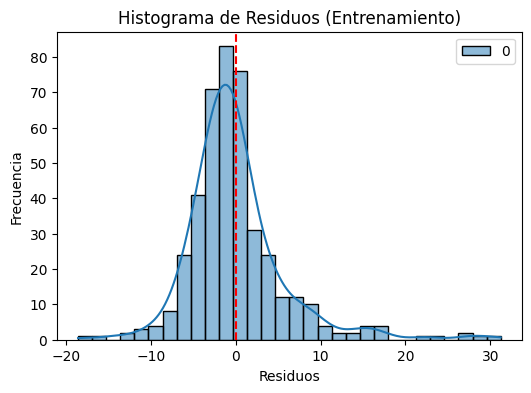

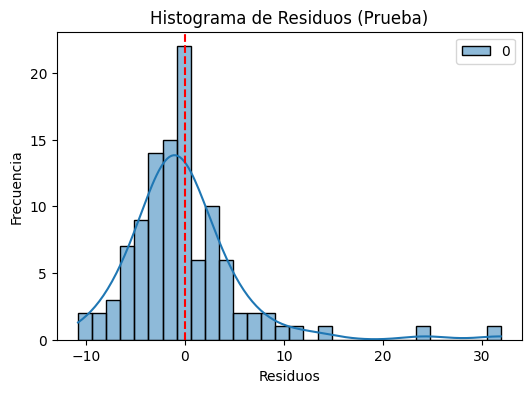

In [150]:
# Graficamos los histogramas de residuos
plot_residuos(x_train_scaled, y_train, x_test_scaled, y_test, W_elastic)

- Se observa que los residuos con los datos de entrenamiento tienen una distribución casi normal.
- El histograma de los residuos con los datos de prueba es asimétrica hacia la derecha, lo cual indica la presencia de outliers.

## Ejercicio 7

Como se evidencia en la tabla de comparación:

In [152]:
comparacion

,Modelos,R2 train,R2 test,RMSE train,RMSE test
0,Regresión lineal,0.637984,0.545689,11.365487,12.358655
1,Gradiente Estocástico,0.635346,0.548468,5.831186,5.785685
2,Gradiente Descendiente,0.629501,0.502277,5.877731,6.074416
3,Gradiente Mini Batch,0.637804,0.544840,5.811497,5.808883
4,Lasso,0.637928,0.543797,5.810505,5.815539
5,Ridge,0.637984,0.545685,5.810059,5.803492
6,Elastic Net,0.637984,0.545670,5.810059,5.803492


- Los modelos han obtenido resultados similares. Todos presentan cierto overfitting con los datos de entrenamiento, ya que los resultados con los datos de prueba son peores. 
- En base al score R2, todos los modelos representan alrededor del 53% de la variación en los datos.
- Es importante observar que si bien la regresión lineal ha tenido un R2 similar a los otros modelos, su RMSE es considerablemente menos deseable (AGREGAR MÁS).